 
 # Steady State Cornering Example
 \begin{equation}\label{eq:DynamicBicycleModel}
        \begin{aligned}
            \dot v_x &=  \frac{1}{m}\big(F_{x}^r \text{cos}(\delta^r)-F_{y}^r \text{sin}(\delta^r)-F_{y}^f \text{sin}(\delta^f)\big) + \omega_z v_y \\
            \dot v_y &= \frac{1}{m}\big (F_{y}^f\text{cos}(\delta^f) + F_{y}^r \text{cos}(\delta^r)+F_{x}^r \text{sin}(\delta^r) \big) - \omega_z v_x \\
            \dot \omega_z &= \frac{1}{I_z} \big(l_f F_{y}^f \text{cos}(\delta^f) - l_r F_{y}^r \text{cos}(\delta^r) - l_r  F_{x}^r \text{sin}(\delta^r) \big) \\
            \dot X &= v_x \text{cos}(\psi) - v_y \text{sin}(\psi)  \\
        \dot Y &= v_x \text{sin}(\psi) + v_y \text{cos}(\psi)  \\
        \dot \psi &= \omega_z  \\
        \end{aligned}
    \end{equation}

In [3]:
import numpy as np
#from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from IPython.display import display
from ipywidgets import interactive, fixed

# This function simulates the one-step  vehicle dynamics
def _DynModel(x, u, deltaT,constantvx):

    x_next= np.zeros(6)
    # Vehicle Parameters BARC
    m  = 1.98
    lf = 0.125
    lr = 0.125
    Iz = 0.024
    Df = 0.8 * m * 9.81 / 2.0
    Cf = 1.25
    Bf = 1.0
    Dr = 0.8 * m * 9.81 / 2.0
    Cr = 1.25
    Br = 1.0

    # # Vehicle Parameters {Passsenger car}
    m=2300 # in Kg
    Iz=4400
    lf=1.5 #length from CoG to front axle in meters
    lr=1.4 #length from CoG to back axle in meters
    lf=1.5 #length from CoG to front axle in meters
    lr=1.4 #length from CoG to back axle in meters
    #TIRE MODEL
    Fz = (1/2)*(m*9.81)/1000; #force in K-newtons
    a1 = -22.1
    a2 = 1011
    a3 = 1078
    a4 = 1.82
    a5 = 0.208
    a6 = 0.000
    a7 = -0.354
    a8 = 0.707;
    Df = a1*(Fz*Fz) + a2*Fz
    BCD = a3*np.sin(a4*np.arctan(a5*Fz))
    Cf = 1.30;
    Bf = BCD/(Cf*Df)
    #Ef = a6*(Fz^2) + a7*Fz + a8;
    Dr=Df
    Cr=Cf
    Br=Bf

    # Extract the value of the inputs and states
    delta = u[0]
    a     = u[1]
    if constantvx > 0:
        vx = constantvx
    else:
        vx    = x[0]
    vy    = x[1]
    wz    = x[2]
    psi   = x[3]
    X     = x[4]
    Y     = x[5]

    # Compute tire slip angle
    alpha_f = delta - np.arctan2( vy + lf * wz, vx )
    alpha_r = - np.arctan2( vy - lf * wz , vx)

    # Compute lateral force at front and rear tire
    Fyf = 2 * Df * np.sin( Cf * np.arctan(Bf * alpha_f ) )
    Fyr = 2 * Dr * np.sin( Cr * np.arctan(Br * alpha_r ) )

    # Propagate the dynamics
    if constantvx>0:
        x_next[0] = constantvx
    else:
        x_next[0] = vx  + deltaT * (a - 1 / m * Fyf * np.sin(delta) + wz*vy)
    x_next[1] = vy  + deltaT * (1 / m * (Fyf * np.cos(delta) + Fyr) - wz * vx)
    x_next[2] = wz  + deltaT * (1 / Iz *(lf * Fyf * np.cos(delta) - lr * Fyr) )
    x_next[3] = psi + deltaT * (wz)
    x_next[4] =   X + deltaT * ((vx * np.cos(psi) - vy * np.sin(psi)))
    x_next[5] =   Y + deltaT * (vx * np.sin(psi)  + vy * np.cos(psi))

    # Addd Noises
    #noise_vx = np.maximum(-0.05, np.minimum(np.random.randn() * 0.01, 0.05))
    #noise_vy = np.maximum(-0.1, np.minimum(np.random.randn() * 0.01, 0.1))
    #noise_wz = np.maximum(-0.05, np.minimum(np.random.randn() * 0.005, 0.05))
    #x_next[0] = x_next[0] + 0.1*noise_vx
    #x_next[1] = x_next[1] + 0.1*noise_vy
    #x_next[2] = x_next[2] + 0.1*noise_wz

    return x_next,alpha_f,alpha_r

In [10]:
def sim(constantsteering,constantvx):
    # Sampling time
    deltaT = 0.01
    # Simulation steps
    Tsim=100
    simSteps=int(Tsim/deltaT)

    # initialization
    x= np.zeros((simSteps,6))
    u= np.zeros((simSteps,2))
    alpha_f= np.zeros(simSteps)
    alpha_r= np.zeros(simSteps)
    x[0, :]=[0,0,0,0,0,0]

    # simulate system
    for t in range(0,simSteps-1):
        u[t, :] = [constantsteering * np.pi / 180, 0]
        x[t + 1, :], alpha_f[t], alpha_r[t] = _DynModel(x[t, :], u[t, :],deltaT,constantvx)

    # plot results
    plt.figure(1)
    plt.plot(x[:,4],x[:,5],'-',linewidth=2,label='CarTrajectory'+'_try:'+str(constantvx))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.figure(2)
    plt.plot(alpha_f,'-',linewidth=2,label='alpha_f'+'_try:'+str(constantvx))
    plt.plot(alpha_r,'-',linewidth=2,label='alpha_r'+'_try:'+str(constantvx))
    plt.xlabel('time')
    plt.ylabel('alpha')
    plt.legend()
    #plt.show()
    return x,u,simSteps
    
w=interactive(sim,constantsteering=(-20.0,20.0),constantvx=(0.0,3.0))
display(w)

interactive(children=(FloatSlider(value=0.0, description='constantsteering', max=20.0, min=-20.0), FloatSlider…

RuntimeError: Requested MovieWriter (ffmpeg) not available

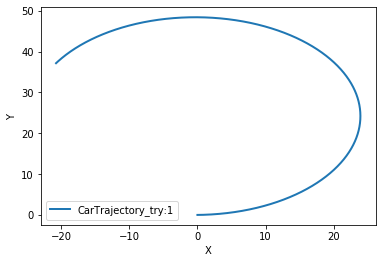

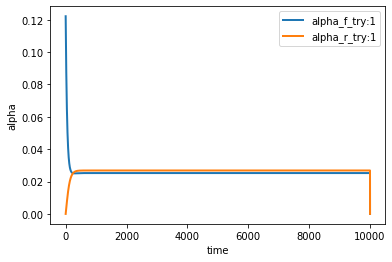

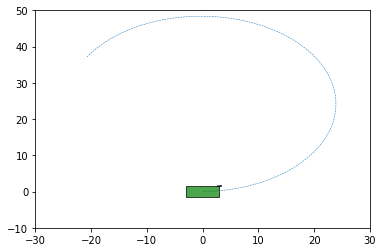

In [12]:
x,u,simSteps=sim(7,1)
from IPython.display import HTML
def animation_xy(x,u,simSteps):
    # for infor read: https: // jakevdp.github.io / blog / 2013 / 05 / 28 / a - simple - animation - the - magic - triangle /
    P1 = np.array([[1, 1], [1,-1], [-1, -1], [-1, 1]])
    fig=plt.figure()
    ax = plt.axes(xlim=(-30, 30), ylim=(-10, 50))
    plt.plot(x[:,4],x[:,5],'--',linewidth=0.5)
    kwds = dict(ec='k', alpha=0.7, closed=True,zorder=10)
    rec = [ax.add_patch(plt.Polygon(0 * P1, fc='g', **kwds)),
                          ax.add_patch(plt.Polygon(0 * P1, fc='b', **kwds))]

    l = 3; w = 1.5

    def animate(t):
        t=t*20 #speedup animation
        if t<simSteps:
            lw=0.4
            ww=0.1
            psi   = x[t,3]
            X     = x[t,4]
            Y     = x[t,5]
            delta = u[t,0]
            car_x = [ X + l * np.cos(psi) - w * np.sin(psi), X + l*np.cos(psi) + w * np.sin(psi),
                      X - l * np.cos(psi) + w * np.sin(psi), X - l * np.cos(psi) - w * np.sin(psi)]
            car_y = [ Y + l * np.sin(psi) + w * np.cos(psi), Y + l * np.sin(psi) - w * np.cos(psi),
                      Y - l * np.sin(psi) - w * np.cos(psi), Y - l * np.sin(psi) + w * np.cos(psi)]
            lfwheel_x = [ car_x[0] + lw * np.cos(psi+delta) - ww * np.sin(psi+delta), car_x[0]+ lw*np.cos(psi+delta) + ww * np.sin(psi+delta),
                      car_x[0] - lw * np.cos(psi+delta) + ww * np.sin(psi+delta), car_x[0] - lw * np.cos(psi+delta) - ww * np.sin(psi+delta)]
            lfwheel_y = [car_y[0] + lw * np.sin(psi+delta) + ww * np.cos(psi+delta), car_y[0] + lw * np.sin(psi+delta) - ww * np.cos(psi+delta),
                     car_y[0] - lw * np.sin(psi+delta) - ww * np.cos(psi+delta), car_y[0] - lw * np.sin(psi+delta) + ww * np.cos(psi+delta)]

            rec[0].set_xy(np.array([car_x, car_y]).T)
            rec[1].set_xy(np.array([lfwheel_x, lfwheel_y ]).T)
        return rec
    anim = animation.FuncAnimation(fig, animate, frames=simSteps, interval=1)
    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    HTML(anim.to_html5_video())
    plt.show()


animation_xy(x,u,simSteps)